# Testing

## Utilities

We havily rely on the high-level transformers library and its datsets wrapper.

In [ ]:
!pip install transformers datasets rouge_score
!pip install wandb -qqq

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 269 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 36.7 MB/s 
     |████████████████████████████████| 636 kB 39.7 MB/s 
     |████████████████████████████████| 895 kB 47.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 76 kB 2.5 MB/s 
     |████████████████████████████████| 1.3 MB 37.7 MB/s 
     |████████████████████████████████| 243 kB 46.6 MB/s 
     |████████████████████████████████| 119 kB 44.5 MB/s 
     |████████████████████████████████| 142 kB 45.7 MB/s 
     |████████████████████████████████| 294 kB 49.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.0
    Uninstalling tqdm-4.62.0:
      Successfully uninstalled tqdm-4.62.0
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |███████

In [ ]:
from collections import OrderedDict
import subprocess
import time
import xml.etree.ElementTree
import torch
import transformers
import datasets
from dataclasses import dataclass, field
from typing import Optional
import wandb
import os
import shutil
import json
from datetime import datetime
import numpy as np

### Weights and biases login

[Weights and biases](https://wandb.ai) is a library for versioning models&datasets and for monitoring the training proces of machine learning models. It allows to collect data from system, metrics and weights.
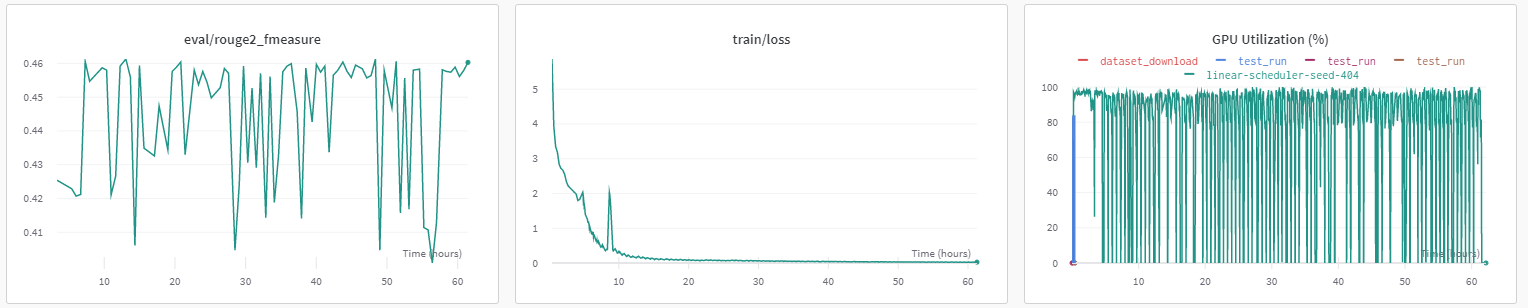 

And we preprare to load a learned model.

In [ ]:
wandb.login()
transformers.set_seed(404)
entity = 'tvn_only'
project = 'tvn_psc_v6'
training_checkpoint_version = 'tvn_only/tvn_psc_v6/training_checkpoint:v6'

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Prepare tokenizer
We are using the tokenizer from the original HerBERT model that we used for our encoder-decoder model.

In [ ]:
# Tokenizer setup
tokenizer_name = 'allegro/herbert-klej-cased-tokenizer-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

### Load model

We download our trained model from wandb.ai artifact.

In [ ]:
wandb_run = wandb.init(project=project, name='test_run', entity=entity)

checkpoint_artifact = wandb_run.use_artifact(training_checkpoint_version, type='checkpoint') 
last_checkpoint_path = checkpoint_artifact.download()

batch_size = 8
bert2bert = transformers.AutoModelForSeq2SeqLM.from_pretrained(last_checkpoint_path).cuda()


encoder_max_length = 512
decoder_max_length = 128

wandb: Currently logged in as: pgrabinski (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact training_checkpoint:v6, 3180.99MB. 12 files... Done. 0:0:0


### Dataset download

In [ ]:
artifact = wandb_run.use_artifact('pns/psc/tvn_psc:v6', type='dataset')
artifact_dir = artifact.download()
test_data = datasets.load_dataset('csv',data_files={'test': artifact_dir+'/tvn_test.csv'}, split='test')
print(f'Length of the test set: {len(test_data)}')

wandb: Downloading large artifact tvn_psc:v6, 360.49MB. 3 files... Done. 0:0:0


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-39dca8a69e17ffd0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-39dca8a69e17ffd0/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.
Length of the test set: 6128


In [ ]:
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

## Run the test

In [ ]:
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # max_length for the encoder is 512
    inputs = tokenizer(batch["body_text"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = bert2bert.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["body_text"])

pred_str = results["pred"]
label_str = results["summary"]

composed = list(zip(label_str, pred_str, test_data["body_text"]))

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)

  0%|          | 0/766 [00:00<?, ?ba/s]

Score(precision=0.11631457624027565, recall=0.13873795780919332, fmeasure=0.12331028546657156)


## Results

We can see the first ten summaries

In [ ]:
for i in range(10):
    print(f'Summary GT ({len(composed[i][0])}): {composed[i][0]}')
    print(f'Summary Pred ({len(composed[i][1])}): {composed[i][1]}')
    print(f'Body text ({len(composed[i][2])}): {composed[i][2]}')
    print(f'{"-"*40}')

Summary GT (261): Nieznani sprawcy obrabowali Muzeum Kultury Łemkowskiej w Zyndranowej (woj. podkarpackie). Sforsowali dwie kłódki, metalową kratę i drzwi do muzeum. Zabrali mundury wojskowe, hełmy, pozostałości karabinów, bagnety, sprzączki z pasów oraz wiele innych eksponatów.
Summary Pred (251): Włamał się do muzeum w Zyndranowej ( Podkarpacie ) i ukradł między innymi mundury niemieckie, mundury armii czechosłowackiej i niemieckiej oraz sprzęt wojskowy. Sprawca został już zatrzymany, a trop został sprawdzany. Grozi mu do pięciu lat więzienia.
Body text (1090): - Najbardziej ucierpiała kolekcja eksponatów wojennych (militariów) z czasów I i II wojny światowej – informują przedstawiciele muzeum. Jak dodają, wciąż trwa szacowanie poniesionych strat. – Nie da się wycenić ich wartości materialnej. Znaczenie ma jednak ich wartość historyczna – podkreśla Bohdan Gocz, przewodniczący Towarzystwa na Rzecz Rozwoju Muzeum Kultury Łemkowskiej w Zyndranowej. Złodziej zabrał między innymi mundury 

And we can see some sampled summaries

In [ ]:
for i in list(np.random.randint(0, len(results), size=(10,))):
    print(f'Summary GT ({len(composed[i][0])}): {composed[i][0]}')
    print(f'Summary Pred ({len(composed[i][1])}): {composed[i][1]}')
    print(f'Body text ({len(composed[i][2])}): {composed[i][2]}')
    print(f'{"-"*40}')

Summary GT (357): Mężczyzna podejrzany o podpalenie biura poselskiego minister Beaty Kempy usłyszał zarzut o charakterze terrorystycznym. Grozi mu za to do 15 lat więzienia. 40-letni Sebastian K. przyznał się do winy. Jak powiedział, kierował się żalem do rządzącej koalicji. Decyzją sądu został aresztowany. Jednak nie za atak na biuro poselskie, a za produkcję narkotyków. 
Summary Pred (319): 40-letni mężczyzna został zatrzymany w sprawie ataku na biuro posłanki Beaty Kempy w Sycowie ( Dolnośląskie ). Jak ustalili śledczy, mężczyzna działał z powodu przynależności politycznej posłanki, w celu zmuszenia rządu do zaniechania określonych czynności. Mężczyzna usłyszał dwa zarzuty. Grozi mu do 15 lat więzienia.
Body text (3823): W nocy z 11 na 12 grudnia policjanci odebrali zgłoszenie o włamaniu do biura poselskiego Beaty Kempy w Sycowie. - Funkcjonariusze stwierdzili jednak, że doszło do pożaru. Na miejsce wezwano straż pożarną - informowała Małgorzata Klaus z Prokuratury Okręgowej we Wroc

## Upload results

In [ ]:
test_results_dict = {'summary_gt':[], 'summary_pred':[], 'body_text':[]}
for gt, pred, body in composed:
    test_results_dict['summary_gt'].append(gt)
    test_results_dict['summary_pred'].append(pred)
    test_results_dict['body_text'].append(body)

In [ ]:
test_results_with_id_dict = {'model_artifact_id': training_checkpoint_version, 'dict': test_results_dict}

In [ ]:
with open('./results.json', 'w') as file:
    json.dump(test_results_with_id_dict, file)
results_artifact = wandb.Artifact('test_results', type='results')
results_artifact.add_file('./results.json')
wandb_run.log_artifact(results_artifact)
results_artifact.wait()

<Artifact QXJ0aWZhY3Q6MjQyNjA0Mjc=>

In [ ]:
wandb.finish()